### Using Machine Learning to generate a time-variant data for Hofstede's cultural values

Hofstede's cultural values are perhaps the most widely used country-level measures of cultures. However, they were collected in the 1980s-90s, without updates over time. While cultures evolve slowly, recent evidence suggests it does change over a long term. In a recent paper <b>(Chen, Duran, Sauerwald, Hitt, and van Essen, 2021)</b>, I used machine learning to use a panel data from the World Values Survey to predict the time-variant cultural values along Hofstede's cultural value dimensions.

Below is an example of coding to create a panel data on Individualism (INV) and Uncertainty Avoidance (UAI) indices.

Please quote the following paper:

<b>Chen, V. Z., Duran, P., Sauerwald, S., Hitt, M. A., & Van Essen, M. (2021). Multistakeholder Agency: Stakeholder Benefit Alignment and National Institutional Contexts. *Journal of Management, In-Press*.https://doi.org/10.1177/01492063211054403</b>

In [1]:
# load basic packages
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# load visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# load statistical packages
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression as Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from sklearn.tree import DecisionTreeRegressor as Tree
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor as NN

from sklearn.ensemble import AdaBoostRegressor as Boost
from sklearn.ensemble import BaggingRegressor as Bagging
from sklearn.ensemble import ExtraTreesRegressor as ExtraTree
from sklearn.ensemble import GradientBoostingRegressor as Gradient
from sklearn.ensemble import RandomForestRegressor as RF

#### Load the panel data from the *World Values Survey*, including questions that are relevant to *Individualism* and *Uncertainty Avoidance*.
Reference: Beugelsdijk, S., Maseland, R., & Van Hoorn, A. (2015). Are Scores on Hofstede's Dimensions of National Culture Stable over Time? A Cohort Analysis. Global Strategy Journal, 5(3), 223-240.

In [2]:
wvs = pd.read_csv('wvs2hof.csv')
wvs = wvs.drop(columns = ['S020'])
print(wvs.columns)

for i in wvs.columns:
    if 'wvs' in i:
        wvs.loc[(wvs[i] < 0), i] = None

wvs = wvs.dropna(axis=1, how='all')
            
for i in wvs.columns:
    if 'wvs' in i:
        wvs[i] = wvs.groupby(['country_iso3','S002'])[i].transform(lambda x: x.fillna(x.mean()))
        wvs[i] = wvs.groupby(['country_iso3'])[i].transform(lambda x: x.fillna(x.mean()))
        
wvs.describe().round(2).T

Index(['country', 'country_iso2', 'country_iso3', 'S002', 'INV_wvs_D021',
       'INV_wvs_E017', 'INV_wvs_E059', 'INV_wvs_E124', 'INV_wvs_G023',
       'INV_wvs_A037', 'INV_wvs_A043B', 'INV_wvs_D079', 'INV_wvs_D080',
       'INV_wvs_F144', 'INV_wvs_survself', 'INV_wvs_D054', 'INV_wvs_E036',
       'INV_wvs_F118', 'INV_wvs_F120', 'UAI_wvs_C013', 'UAI_wvs_E144',
       'UAI_wvs_A195', 'UAI_wvs_E069_12', 'UAI_wvs_E069_17', 'UAI_wvs_E128',
       'UAI_wvs_A165'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,113593.0,1.23,0.29,1.0,1.10,1.14,1.23,3.00
INV_wvs_E059,85163.0,2.74,0.69,1.0,2.53,2.71,3.00,5.00
INV_wvs_E124,334799.0,2.40,0.75,1.0,2.00,2.34,3.00,4.00
INV_wvs_G023,311761.0,2.06,0.72,1.0,1.80,2.00,2.22,4.00
INV_wvs_A043B,270929.0,0.28,0.28,0.0,0.08,0.23,0.36,1.00
INV_wvs_D079,237938.0,1.66,0.37,1.0,1.53,1.68,1.84,4.00
INV_wvs_D080,237938.0,1.68,0.38,1.0,1.58,1.69,1.80,4.00
INV_wvs_F144,109961.0,5.56,1.80,1.0,4.59,5.73,6.77,10.00
INV_wvs_survself,335314.0,0.69,0.35,0.0,0.51,0.66,0.79,3.37
INV_wvs_D054,345933.0,1.78,0.73,1.0,1.00,2.00,2.00,4.00


#### Load *Hofstede*'s country-level data

In [3]:
hof = pd.read_excel('hofstedes6.xlsx')
hof = hof.rename(columns = {"IND": "INV"})
hof = hof[['country_iso3', 'INV', 'UAI']]
print(hof.columns)

Index(['country_iso3', 'INV', 'UAI'], dtype='object')


#### Merge *World Values Survey* and *Hofstede* data

In [4]:
wvs2hof = wvs.merge(hof, left_on = ['country_iso3'], right_on = ['country_iso3'])

#### MinMax normalization to standardize the scale of data.

In [5]:
def normalize(df):
    try:
        result = df.copy()
        max_value = df.max()
        min_value = df.min()
        result = (df - min_value) / (max_value - min_value)
        return result
    except:
        return df
    
for i in wvs2hof.columns:
    if wvs2hof[i].dtype != 'O':
        wvs2hof[i] = normalize(wvs2hof[i])
wvs2hof.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,106523.0,0.12,0.15,0.0,0.05,0.07,0.18,1.0
INV_wvs_E059,78093.0,0.43,0.18,0.0,0.38,0.42,0.53,1.0
INV_wvs_E124,307876.0,0.46,0.25,0.0,0.33,0.44,0.67,1.0
INV_wvs_G023,284638.0,0.35,0.23,0.0,0.27,0.33,0.41,1.0
INV_wvs_A043B,247506.0,0.28,0.28,0.0,0.09,0.23,0.36,1.0
INV_wvs_D079,222650.0,0.22,0.12,0.0,0.17,0.23,0.28,1.0
INV_wvs_D080,222650.0,0.23,0.13,0.0,0.19,0.23,0.27,1.0
INV_wvs_F144,102891.0,0.50,0.20,0.0,0.40,0.53,0.57,1.0
INV_wvs_survself,309277.0,0.20,0.10,0.0,0.15,0.19,0.24,1.0
INV_wvs_D054,317093.0,0.26,0.24,0.0,0.00,0.33,0.33,1.0


#### Set train data to be 1981 - 1993 panel, and test data to be post-1993

In [6]:
train = wvs2hof[(wvs2hof.S002 =='1981-1984') | (wvs2hof.S002 =='1989-1993')].dropna(axis=1, how='all')
test = wvs2hof[(wvs2hof.S002 !='1981-1984') & (wvs2hof.S002 !='1989-1993')].dropna(axis=1, how='all')
jointcolumns = train.columns.intersection(test.columns)
print('column list:', jointcolumns)

column list: Index(['country', 'country_iso2', 'country_iso3', 'S002', 'INV_wvs_E017',
       'INV_wvs_E059', 'INV_wvs_E124', 'INV_wvs_G023', 'INV_wvs_A043B',
       'INV_wvs_D079', 'INV_wvs_D080', 'INV_wvs_F144', 'INV_wvs_survself',
       'INV_wvs_D054', 'INV_wvs_E036', 'INV_wvs_F118', 'INV_wvs_F120',
       'UAI_wvs_C013', 'UAI_wvs_A195', 'UAI_wvs_E069_12', 'UAI_wvs_E069_17',
       'UAI_wvs_E128', 'UAI_wvs_A165', 'INV', 'UAI'],
      dtype='object')


In [7]:
train_INV_columns = [i for i in jointcolumns if 'INV' in i]
test_INV_columns = [i for i in jointcolumns if 'INV_' in i]

train_INV = train[['country'] + train_INV_columns].dropna()
train_INV_y = train_INV['INV']
train_INV_x = train_INV[[i for i in train_INV.columns if '_wvs' in i]]
print("="*100 + "\n train INV y\n" + "="*100)
print(train_INV_y.describe().round(2).T)
print("="*100 + "\n train INV x\n" + "="*100)
print(train_INV_x.describe().round(2).T)

test_INV_na = test[['country', 'S002'] + test_INV_columns]
print("="*100 + "\n test INV with NaN\n" + "="*100)
print(test_INV_na.groupby('S002').describe().round(2).T)

test_INV = test[['country', 'S002'] + test_INV_columns].dropna()
test_INV_x = test_INV[[i for i in test_INV.columns if '_wvs' in i]]
print("="*100 + "\n test INV x\n" + "="*100)
print(test_INV_x.describe().round(2).T)
test_INV['S002'].value_counts()

 train INV y
count    17781.00
mean         0.41
std          0.11
min          0.20
25%          0.28
50%          0.47
75%          0.49
max          0.64
Name: INV, dtype: float64
 train INV x
                    count  mean   std   min   25%   50%   75%   max
INV_wvs_E017      17781.0  0.10  0.23  0.00  0.00  0.00  0.10  1.00
INV_wvs_E059      17781.0  0.41  0.27  0.00  0.25  0.49  0.54  1.00
INV_wvs_E124      17781.0  0.49  0.07  0.35  0.45  0.50  0.54  0.58
INV_wvs_G023      17781.0  0.39  0.18  0.19  0.31  0.35  0.36  0.76
INV_wvs_A043B     17781.0  0.30  0.20  0.08  0.14  0.32  0.36  0.74
INV_wvs_D079      17781.0  0.23  0.04  0.15  0.21  0.24  0.26  0.30
INV_wvs_D080      17781.0  0.23  0.03  0.16  0.22  0.23  0.25  0.26
INV_wvs_F144      17781.0  0.48  0.34  0.00  0.22  0.56  0.78  1.00
INV_wvs_survself  17781.0  0.22  0.10  0.00  0.19  0.21  0.24  0.98
INV_wvs_D054      17781.0  0.28  0.08  0.18  0.22  0.28  0.32  0.43
INV_wvs_E036      17781.0  0.48  0.27  0.00  0.33  0.46 

2010-2014    16692
2005-2009    12392
1994-1998    12230
1999-2004     8588
Name: S002, dtype: int64

In [8]:
train_UAI_columns = [i for i in jointcolumns if 'UAI' in i]
test_UAI_columns = [i for i in jointcolumns if 'UAI_' in i]

train_UAI = train[['country'] + train_UAI_columns].dropna()
train_UAI_y = train_UAI['UAI']
train_UAI_x = train_UAI[[i for i in train_UAI.columns if '_wvs' in i]]
print("="*100 + "\n train UAI y\n" + "="*100)
print(train_UAI_y.describe().round(2).T)
print("="*100 + "\n train UAI x\n" + "="*100)
print(train_UAI_x.describe().round(2).T)

test_UAI_na = test[['country', 'S002'] + test_UAI_columns]
print("="*100 + "\n test UAI with NaN\n" + "="*100)
print(test_UAI_na.groupby('S002').describe().round(2).T)

test_UAI = test[['country', 'S002'] + test_UAI_columns].dropna()
test_UAI_x = test_UAI[[i for i in test_UAI.columns if '_wvs' in i]]
print("="*100 + "\n test UAI x\n" + "="*100)
print(test_UAI_x.describe().round(2).T)
test_UAI['S002'].value_counts()

 train UAI y
count    34533.00
mean         0.65
std          0.23
min          0.23
25%          0.44
50%          0.73
75%          0.84
max          0.94
Name: UAI, dtype: float64
 train UAI x
                   count  mean   std  min   25%   50%   75%   max
UAI_wvs_C013     34533.0  0.62  0.47  0.0  0.00  1.00  1.00  1.00
UAI_wvs_A195     34533.0  0.57  0.11  0.3  0.51  0.59  0.64  0.77
UAI_wvs_E069_12  34533.0  0.61  0.22  0.0  0.55  0.67  0.75  1.00
UAI_wvs_E069_17  34533.0  0.44  0.30  0.0  0.33  0.33  0.67  1.00
UAI_wvs_E128     34533.0  0.32  0.29  0.0  0.11  0.25  0.44  1.00
UAI_wvs_A165     34533.0  0.67  0.45  0.0  0.00  1.00  1.00  1.00
 test UAI with NaN
S002                   1994-1998  1999-2004  2005-2009  2010-2014
UAI_wvs_C013    count   69913.00   50046.00   55823.00   58885.00
                mean        0.70       0.80       0.71       0.71
                std         0.44       0.40       0.15       0.13
                min         0.00       0.00       0.34     

2010-2014    58885
1994-1998    57583
2005-2009    55823
1999-2004    39696
Name: S002, dtype: int64

#### Run multiple regression and machine learning analysis of the training data and compare their performance scores (1 being the best)

##### First, use the major machine learning methods, including
- Linear Regressor without regularization
- Linear Regressor with Ridge regularization and cross-validation
- Linear Regressor with Lasso regularization and cross-validation
- Epsilon-Support Vector Regressor
- Gradient Boosting Regressor
- AdaBoost Regressor
- Bagging Regresor
- Decision Trees Regressor
- Extra-Trees Regressor
- Random Forests Regressor
- Neural Network Regressor

#####  Second, randomly reordering the training sample, and split it into 0.7 training set and 0.3 development (evaluation) set; The accuracy scores (R-squared) will be calculated by comparing the predicted values and the true values in the development (evaluation) set.

<AxesSubplot:ylabel='Model'>

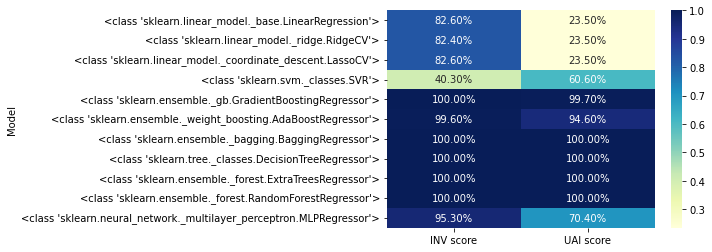

In [14]:
scoresINV = []
scoresUAI = []
model_list = [Reg, RidgeCV, LassoCV, SVR, Gradient, Boost, Bagging, Tree, ExtraTree, RF, NN]
for i in model_list:
    model = i()   
    from sklearn.model_selection import train_test_split
    data_train, data_test, target_train, target_test = train_test_split(train_INV_x, train_INV_y, 
                                                                        train_size = .7, random_state=123) 
    _ = model.fit(data_train, target_train)
    scoresINV.append(model.score(data_test, target_test).round(3)) # out-of-sample score
    
    data_train, data_test, target_train, target_test = train_test_split(train_UAI_x, train_UAI_y,
                                                                        train_size = .7, random_state=123) 
    _ = model.fit(data_train, target_train)
    scoresUAI.append(model.score(data_test, target_test).round(3)) # out-of-sample score

sns.heatmap(pd.DataFrame(zip(model_list, scoresINV, scoresUAI), 
            columns = ['Model', 'INV score', 'UAI score']).set_index('Model'), 
            annot = True, fmt=".2%", cmap="YlGnBu")

#### Use the best performing method to predict Hofstede's scores in the test data.

In [15]:
BestMethod_INV = model_list[scoresINV.index(max(scoresINV))]
BestMethod_UAI = model_list[scoresUAI.index(max(scoresUAI))]

reg_INV = BestMethod_INV().fit(train_INV_x, train_INV_y)
reg_UAI = BestMethod_UAI().fit(train_UAI_x, train_UAI_y)
test_INV['INV'] = reg_INV.predict(test_INV_x)
test_UAI['UAI'] = reg_UAI.predict(test_UAI_x)

In [17]:
test['INV'] = test_INV['INV']
test['UAI'] = test_UAI['UAI']
test.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,79619.0,0.12,0.10,0.03,0.06,0.08,0.18,0.40
INV_wvs_E059,57921.0,0.43,0.11,0.17,0.38,0.42,0.49,0.72
INV_wvs_E124,273343.0,0.46,0.26,0.00,0.33,0.37,0.67,1.00
INV_wvs_G023,250105.0,0.35,0.24,0.00,0.27,0.33,0.41,1.00
INV_wvs_A043B,216840.0,0.28,0.29,0.00,0.08,0.23,0.36,1.00
INV_wvs_D079,190133.0,0.22,0.13,0.00,0.17,0.23,0.30,1.00
INV_wvs_D080,190133.0,0.23,0.14,0.00,0.19,0.23,0.28,1.00
INV_wvs_F144,77377.0,0.50,0.12,0.23,0.40,0.53,0.57,0.70
INV_wvs_survself,273354.0,0.20,0.10,0.00,0.15,0.19,0.24,1.00
INV_wvs_D054,281170.0,0.26,0.25,0.00,0.00,0.33,0.33,1.00


In [18]:
train.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,26904.0,0.10,0.23,0.00,0.00,0.00,0.08,1.00
INV_wvs_E059,20172.0,0.44,0.29,0.00,0.25,0.49,0.54,1.00
INV_wvs_E124,34533.0,0.45,0.10,0.20,0.41,0.45,0.54,0.62
INV_wvs_G023,34533.0,0.35,0.16,0.10,0.28,0.31,0.36,0.76
INV_wvs_A043B,30666.0,0.28,0.17,0.08,0.17,0.26,0.35,0.74
INV_wvs_D079,32517.0,0.22,0.04,0.13,0.20,0.23,0.24,0.34
INV_wvs_D080,32517.0,0.23,0.04,0.16,0.20,0.22,0.25,0.32
INV_wvs_F144,25514.0,0.49,0.34,0.00,0.22,0.53,0.78,1.00
INV_wvs_survself,35923.0,0.20,0.10,0.00,0.15,0.21,0.23,0.98
INV_wvs_D054,35923.0,0.31,0.12,0.09,0.22,0.32,0.39,0.61


In [19]:
# wvs2hof = wvs2hof.drop(columns = ['INV', 'UAI'])
print('S002:\n', wvs2hof['S002'].value_counts())
wvs2hof.describe().round(2).T

S002:
 2005-2009    79779
2010-2014    74027
1994-1998    72993
1999-2004    55570
1989-1993    23307
1981-1984    12616
Name: S002, dtype: int64


,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,106523.0,0.12,0.15,0.0,0.05,0.07,0.18,1.0
INV_wvs_E059,78093.0,0.43,0.18,0.0,0.38,0.42,0.53,1.0
INV_wvs_E124,307876.0,0.46,0.25,0.0,0.33,0.44,0.67,1.0
INV_wvs_G023,284638.0,0.35,0.23,0.0,0.27,0.33,0.41,1.0
INV_wvs_A043B,247506.0,0.28,0.28,0.0,0.09,0.23,0.36,1.0
INV_wvs_D079,222650.0,0.22,0.12,0.0,0.17,0.23,0.28,1.0
INV_wvs_D080,222650.0,0.23,0.13,0.0,0.19,0.23,0.27,1.0
INV_wvs_F144,102891.0,0.50,0.20,0.0,0.40,0.53,0.57,1.0
INV_wvs_survself,309277.0,0.20,0.10,0.0,0.15,0.19,0.24,1.0
INV_wvs_D054,317093.0,0.26,0.24,0.0,0.00,0.33,0.33,1.0


#### The test (predict) data now includes Hofstede's scores, merge it with the training data into a full data

In [20]:
hof2 = ['INV', 'UAI']
wvs2hof.drop(columns = hof2, inplace = True)
wvs2hof = wvs2hof.merge(test[hof2], how = 'outer', left_index = True, right_index = True)
wvs2hof = wvs2hof.merge(train[hof2], how = 'outer', left_index = True, right_index = True)
for i in hof2:
    wvs2hof[i] = wvs2hof[[i+'_x', i+'_y']].max(axis=1)
    wvs2hof.drop(columns = [i+'_x', i+'_y'], inplace = True)
wvs2hof.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
INV_wvs_E017,106523.0,0.12,0.15,0.00,0.05,0.07,0.18,1.00
INV_wvs_E059,78093.0,0.43,0.18,0.00,0.38,0.42,0.53,1.00
INV_wvs_E124,307876.0,0.46,0.25,0.00,0.33,0.44,0.67,1.00
INV_wvs_G023,284638.0,0.35,0.23,0.00,0.27,0.33,0.41,1.00
INV_wvs_A043B,247506.0,0.28,0.28,0.00,0.09,0.23,0.36,1.00
INV_wvs_D079,222650.0,0.22,0.12,0.00,0.17,0.23,0.28,1.00
INV_wvs_D080,222650.0,0.23,0.13,0.00,0.19,0.23,0.27,1.00
INV_wvs_F144,102891.0,0.50,0.20,0.00,0.40,0.53,0.57,1.00
INV_wvs_survself,309277.0,0.20,0.10,0.00,0.15,0.19,0.24,1.00
INV_wvs_D054,317093.0,0.26,0.24,0.00,0.00,0.33,0.33,1.00


#### Convert the individual-time panel data into a country-time panel data

In [21]:
hof_predicted = wvs2hof.sort_values(by = ['country', 'S002']).groupby(['country', 'S002'])[['INV', 'UAI']].mean()
hof_predicted.round(4).to_csv("wvs2hof_predicted.csv")
hof_predicted.round(4)

INV     UAI
country  S002                  
Albania  1994-1998  NaN     NaN
         1999-2004  NaN     NaN
Algeria  1999-2004  NaN  0.8472
         2010-2014  NaN  0.6919
Andorra  2005-2009  NaN     NaN
...                 ...     ...
Vietnam  1999-2004  NaN  0.2366
         2005-2009  NaN  0.4051
Zambia   2005-2009  NaN     NaN
Zimbabwe 1999-2004  NaN  0.8410
         2010-2014  NaN  0.6748

[217 rows x 2 columns]

#### Convert the unbalanced panel data into a balanced panel data, and impute missing values using a linear function

In [22]:
hof_predicted = hof_predicted.sort_values(by = ['country', 'S002']).reset_index()
c = hof_predicted['country'].unique()
y = hof_predicted['S002'].unique()

In [23]:
from itertools import product
hof_predicted_all = pd.DataFrame(list(product(c, y)), columns =['country', 'S002']).sort_values(by = ['country', 'S002'])

In [24]:
hof_predicted_all = hof_predicted_all.merge(hof_predicted, how='outer', on=['country', 'S002']).sort_values(by = ['country', 'S002'])

In [25]:
for i in ['INV', 'UAI']:
    hof_predicted_all[i] = hof_predicted_all.groupby(['country'])[i].apply(lambda x: x.interpolate(method = 'linear', limit_area = 'inside'))
    hof_predicted_all[i] = hof_predicted_all.groupby(['country'])[i].apply(lambda x: x.interpolate(method = 'linear', limit_area = 'outside', limit_direction = 'forward'))
    hof_predicted_all[i] = hof_predicted_all.groupby(['country'])[i].apply(lambda x: x.interpolate(method = 'linear', limit_area = 'outside', limit_direction = 'backward'))
    hof_predicted_all.loc[hof_predicted_all[i] < 0, i] =0
    hof_predicted_all.loc[hof_predicted_all[i] > 1, i] =1
hof_predicted_all

,country,S002,INV,UAI
0,Albania,1981-1984,NaN,NaN
1,Albania,1989-1993,NaN,NaN
2,Albania,1994-1998,NaN,NaN
3,Albania,1999-2004,NaN,NaN
4,Albania,2005-2009,NaN,NaN
...,...,...,...,...
505,Zimbabwe,1989-1993,NaN,0.840995
506,Zimbabwe,1994-1998,NaN,0.840995
507,Zimbabwe,1999-2004,NaN,0.840995
508,Zimbabwe,2005-2009,NaN,0.757917


#### Save the data into a csv file for analysis

In [26]:
hof_predicted_all.to_csv('predicted_HOF_overtime.csv')